# Importación de paquetes iniciales

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import logging
import os
from datetime import datetime, timedelta
from google.cloud import bigquery
import google.auth
from google.oauth2 import service_account
from google.cloud.bigquery.schema import SchemaField
from google.cloud.bigquery.table import Table

# Configuración del sistema de excepciones y logs
Se van a almacenar en una carpeta en el root según las indicaciones de la prueba

In [25]:
# Crear un directorio de registros si no existe
log_dir="logs"
os.makedirs(log_dir, exist_ok=True)

# Configurar la configuración de registro
log_file=os.path.join(log_dir, "application.log")
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
file_handler=logging.FileHandler(log_file)
file_handler.setLevel(logging.ERROR)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logging.getLogger().addHandler(file_handler)

In [26]:
# Define la ruta del archivo
ruta_archivo="datasets/flights.csv"

# Lee el archivo CSV en un DataFrame de pandas
df=pd.read_csv(ruta_archivo, delimiter="|")

# Muestra las primeras filas del DataFrame
df.head()

In [ ]:
df.shape

(1191805, 31)

Se comprueba que el dataset tiene más de un millon de filas como se pide en la prueba y que carga todas las filas del csv.

# EDA

In [ ]:
# Se revisa el tipo de cada columna para identificar si están correctas o se debe hacer algun ajuste
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191805 entries, 0 to 1191804
Data columns (total 31 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   TRANSACTIONID      1191805 non-null  int64  
 1   FLIGHTDATE         1191805 non-null  int64  
 2   AIRLINECODE        1191805 non-null  object 
 3   AIRLINENAME        1191805 non-null  object 
 4   TAILNUM            1034988 non-null  object 
 5   FLIGHTNUM          1191805 non-null  int64  
 6   ORIGINAIRPORTCODE  1191805 non-null  object 
 7   ORIGAIRPORTNAME    1191805 non-null  object 
 8   ORIGINCITYNAME     1191805 non-null  object 
 9   ORIGINSTATE        1180963 non-null  object 
 10  ORIGINSTATENAME    1180963 non-null  object 
 11  DESTAIRPORTCODE    1191805 non-null  object 
 12  DESTAIRPORTNAME    1191805 non-null  object 
 13  DESTCITYNAME       1191805 non-null  object 
 14  DESTSTATE          1180967 non-null  object 
 15  DESTSTATENAME      1180967 non-n

Se identifica que la columna FlightDate deberia ser una fecha, la distancia debería ser un número, Cancelled y Diverted deben tener valor booleano.

In [ ]:
try:
    #Se convierte la fecha
    df['FLIGHTDATE']=pd.to_datetime(df['FLIGHTDATE'], format='%Y%m%d')

    #Se ajusta la columna Distance
    df['DISTANCE']=df['DISTANCE'].str.replace(' miles', '')
    df['DISTANCE']=pd.to_numeric(df['DISTANCE'],errors='raise')
    df['DEPDELAY']=pd.to_timedelta(df['DEPDELAY'], unit='min',errors='ignore',)
    df['TAXIOUT']=pd.to_timedelta(df['TAXIOUT'], unit='min',errors='ignore',)
    df['TAXIIN']=pd.to_timedelta(df['TAXIIN'], unit='min',errors='ignore',)
    df['ARRDELAY']=pd.to_timedelta(df['ARRDELAY'], unit='min',errors='ignore',)
    df['CRSELAPSEDTIME']=pd.to_timedelta(df['CRSELAPSEDTIME'], unit='min',errors='ignore',)
    df['ACTUALELAPSEDTIME']=pd.to_timedelta(df['ACTUALELAPSEDTIME'], unit='min',errors='ignore',)

    #df['TAXIOUT']=df['TAXIOUT'].dt.total_seconds()/60

    #Se ajustan las columnas booleanas
    df['CANCELLED']=df['CANCELLED'].map({'0': False, '1': True, 'True': True, 'False': False, 'T': True, 'F': False})
    df['DIVERTED']=df['DIVERTED'].map({'0': False, '1': True, 'True': True, 'False': False, 'T': True, 'F': False})

except Exception as e:
    logging.exception(f"Se ha presentado una excepcion: {e}")


C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arrays\timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arrays\timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


Aunque no es del todo necesario capturas los errores en este punto pues es muy manual este proceso se deja para probar el sistema logging, si se corre dos veces este bloque se dispara una excepcion por aplicarle .str. a la columna distance que ya es numerica.

Para seguir con las columnas que tiene formato de hora vemos que dos de ellas tienen formato int64 y el resto float64, quiere decir que las int no tienen valores nulos mientras que las otras si, se verifica esto para proceder a su transformació.

In [ ]:
# Convertir columnas a formato fecha hora
columnas_hora = ['CRSDEPTIME','ARRTIME']
for columna in columnas_hora:
    if df[columna].isnull().sum()==0:
        df[columna]=df[columna].astype(str).str.zfill(4)
        df[columna]=pd.to_datetime(df[columna],errors='coerce', format='%H%M').dt.time
        df[columna]=df['FLIGHTDATE'].dt.strftime("%Y-%m-%d") + ' ' + df[columna].apply(str)
        df[columna]=pd.to_datetime(df[columna],errors='coerce')


In [ ]:
# Se verifican los cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191805 entries, 0 to 1191804
Data columns (total 31 columns):
 #   Column             Non-Null Count    Dtype          
---  ------             --------------    -----          
 0   TRANSACTIONID      1191805 non-null  int64          
 1   FLIGHTDATE         1191805 non-null  datetime64[ns] 
 2   AIRLINECODE        1191805 non-null  object         
 3   AIRLINENAME        1191805 non-null  object         
 4   TAILNUM            1034988 non-null  object         
 5   FLIGHTNUM          1191805 non-null  int64          
 6   ORIGINAIRPORTCODE  1191805 non-null  object         
 7   ORIGAIRPORTNAME    1191805 non-null  object         
 8   ORIGINCITYNAME     1191805 non-null  object         
 9   ORIGINSTATE        1180963 non-null  object         
 10  ORIGINSTATENAME    1180963 non-null  object         
 11  DESTAIRPORTCODE    1191805 non-null  object         
 12  DESTAIRPORTNAME    1191805 non-null  object         
 13  DESTCITYNAME

## Datos faltantes

In [ ]:
# Análisis de valores nulos
null_values=df.isnull().sum() / len(df) * 100
print("Porcentaje de valores nulos por columna:")
print(null_values)

Porcentaje de valores nulos por columna:
TRANSACTIONID         0.000000
FLIGHTDATE            0.000000
AIRLINECODE           0.000000
AIRLINENAME           0.000000
TAILNUM              13.157941
FLIGHTNUM             0.000000
ORIGINAIRPORTCODE     0.000000
ORIGAIRPORTNAME       0.000000
ORIGINCITYNAME        0.000000
ORIGINSTATE           0.909713
ORIGINSTATENAME       0.909713
DESTAIRPORTCODE       0.000000
DESTAIRPORTNAME       0.000000
DESTCITYNAME          0.000000
DESTSTATE             0.909377
DESTSTATENAME         0.909377
CRSDEPTIME            0.000168
DEPTIME               2.377486
DEPDELAY              2.377486
TAXIOUT              15.100792
WHEELSOFF            15.104317
WHEELSON             15.235714
TAXIIN               15.227743
CRSARRTIME            0.000000
ARRTIME               2.547900
ARRDELAY              2.622912
CRSELAPSEDTIME        0.035408
ACTUALELAPSEDTIME     2.622912
CANCELLED             0.000000
DIVERTED              0.000000
DISTANCE              0.00000

El porcentaje de datos faltantes en algunos campos va desde 0.9% hasta 15% en otros, en este punto del proceso no se considera eliminar estos registros, se procede a explorar los datos con el fin de decidir si descartar las columnas con alto porcentaje o si utilizar alguna técnica para completar la información faltante.

C:\Users\alejo\AppData\Local\Temp\ipykernel_5648\3462987559.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix=df.corr()


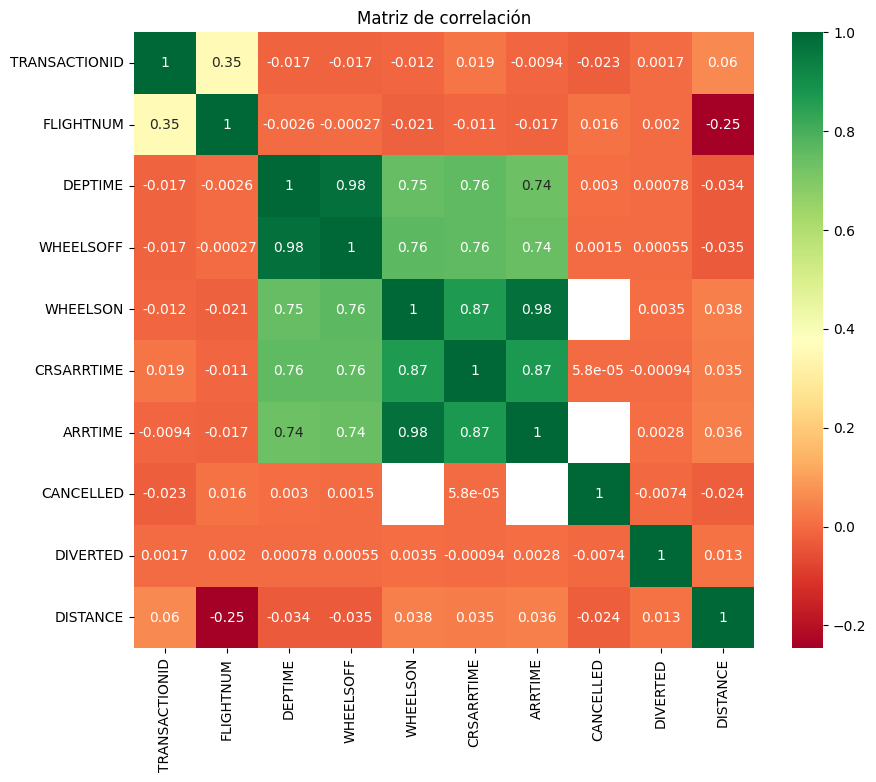

In [ ]:
# Matriz de correlación
correlation_matrix=df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn")
plt.title("Matriz de correlación")
plt.show()

Aunque la matriz de correlación se utiliza más para modelos numéricos y preparar la data para modelos predictivos en este punto nos puede dar una pista si al descartar una columna podríamos afectar otra.

Empezando por la columna que más datos le faltan (TAILNUM) se analiza si es necesario rellenar o no estos valores, esta columna corresponde a la identificación única de cada avión y sin más datos que nos permitan identificar a cada aeronave es imposible conseguir este valor; también se puede apreciar en la matriz que este valor no tiene gran influencia sobre las otras columnas, por lo tanto se dejaran los valores nulos y no se eliminaran estos registros.

Ahora se procede a revisar ORIGINSTATE y ORIGINSTATENAME, como tenemos el código del aeropuerto podemos buscarlo en los aeropuertos de destino y así encontrar la información faltante

In [ ]:
# Crear un diccionario de mapeo entre DESTAIRPORTCODE y DESTSTATE
codigos = df.set_index('DESTAIRPORTCODE')['DESTSTATE'].to_dict()

# Rellenar los valores faltantes en ORIGINSTATE usando el diccionario de mapeo
df['ORIGINSTATE'] = df['ORIGINSTATE'].fillna(df['ORIGINAIRPORTCODE'].map(codigos))

Como esta estrategia no redujo el número de datos faltantes se procede a conectarse a una API gratuita que retorna la información del aeropuerto basado en el código único

In [ ]:
def airport_info(airport_code):

	url = "https://airport-info.p.rapidapi.com/airport"

	querystring = {"iata":airport_code}

	headers = {
		"X-RapidAPI-Key": "6f294ed6f0mshd9fbb45d9c15ffbp112336jsn9ed08e8c22a6",
		"X-RapidAPI-Host": "airport-info.p.rapidapi.com"
	}
	try:
		response = requests.get(url, headers=headers, params=querystring)

	except Exception as e:
		logging.exception(f"Se ha presentado una excepcion al consultar la API: {e}")
		return
	
	print(response.json())

	return response.json()

In [ ]:
# Filtrar el diccionario para obtener solo las claves con valor NaN
codigos_faltantes = {key: value for key, value in codigos.items() if pd.isna(value)}

codigos_completos={}

for key in codigos_faltantes:
    codigos_completos[key]=airport_info(key)['state']

{'id': 5548, 'iata': 'OKC', 'icao': 'KOKC', 'name': 'Will Rogers World Airport', 'location': 'Oklahoma City, Oklahoma, United States', 'street_number': '7100', 'street': 'Terminal Drive', 'city': 'Oklahoma City', 'county': '', 'state': 'Oklahoma', 'country_iso': 'US', 'country': 'United States', 'postal_code': '73159', 'phone': '+1 405-316-3200', 'latitude': 35.393055, 'longitude': -97.600555, 'uct': -300, 'website': 'http://www.flyokc.com/'}
{'id': 7645, 'iata': 'TUL', 'icao': 'KTUL', 'name': 'Tulsa International Airport', 'location': 'Tulsa, Oklahoma, United States', 'street_number': '7777', 'street': 'East Apache Street', 'city': 'Tulsa', 'county': 'Tulsa County', 'state': 'Oklahoma', 'country_iso': 'US', 'country': 'United States', 'postal_code': '74115', 'phone': '+1 918-838-5000', 'latitude': 36.198776, 'longitude': -95.883865, 'uct': -300, 'website': 'http://www.tulsaairports.com/'}
{'id': 3125, 'iata': 'ICT', 'icao': 'KICT', 'name': 'Wichita Dwight D. Eisenhower National Airpor

Como ya se tiene un diccionario con el nombre del estado para cada aeropuerto faltante se agregan los datos al dataframe

In [ ]:
df['ORIGINSTATENAME'] = df['ORIGINSTATENAME'].fillna(df['ORIGINAIRPORTCODE'].map(codigos_completos))
df['DESTSTATENAME'] = df['DESTSTATENAME'].fillna(df['DESTAIRPORTCODE'].map(codigos_completos))

Ahora se completan las columnas ORIGINSTATE Y DESTSTATE, para esto se utiliza otro dataset pequeño con todos los estados y su abreviatura

In [ ]:
# Se carga el dataset
df_estados = pd.read_csv("datasets/us_states.tsv", sep="\t")

# Se extraen los estados y su abreviatura
abreviaturas = df_estados.set_index('name')['state'].to_dict()

# Se elimina el dataset para liberar memoria
del df_estados

In [ ]:
df['ORIGINSTATE'] = df['ORIGINSTATE'].fillna(df['ORIGINSTATENAME'].map(abreviaturas))
df['DESTSTATE'] = df['DESTSTATE'].fillna(df['DESTSTATENAME'].map(abreviaturas))

### Columnas de tiempo

Como los vuelos cancelados tienen valores nulos en la mayoria de las columnas se filtran estos vuelos para poder hacer las operaciones sin problemas

In [ ]:
# Convertir columnas a formato fecha hora
columnas_hora = ['CRSDEPTIME', 'DEPTIME', 'WHEELSOFF', 'WHEELSON', 'CRSARRTIME', 'ARRTIME']
for columna in columnas_hora:
    print(df.loc[df['CANCELLED']==False,columna].isnull().sum())


2
0
151482
152966
0
1752


Para los valores nulos que aún quedan se van a insertan los valores aproximados, por ejemplo hora de despegue programada y si la real es nula se pondrá la programada para poder rellenar los espacios, de todas formas como se vio al inicio estos valores solo corresponden al 2% y no presentan una cantidad estadisticamente considerable

In [ ]:
# Convertir columnas a formato fecha hora
columnas_hora = ['DEPTIME']
for columna in columnas_hora:
    df[columna]=df[columna].astype('Int64').astype(str)
    df[columna]=df[columna].fillna(df['CRSDEPTIME'])
    df[columna] = df[columna].astype(str).str.zfill(4)
    df[columna] = pd.to_datetime(df[columna],errors='coerce', format='%H%M').dt.time
    df[columna] = df['FLIGHTDATE'].dt.strftime("%Y-%m-%d") + ' ' + df[columna].apply(str)
    df[columna] = pd.to_datetime(df[columna], errors='coerce')

columnas_hora = ['ARRTIME']
for columna in columnas_hora:
    df[columna]=df[columna].astype('Int64').astype(str)
    df[columna] = df[columna].astype(str).str.zfill(4)
    df[columna] = pd.to_datetime(df[columna],errors='coerce', format='%H%M').dt.time
    df[columna] = df['FLIGHTDATE'].dt.strftime("%Y-%m-%d") + ' ' + df[columna].apply(str)
    df[columna] = pd.to_datetime(df[columna], errors='coerce')
    df[columna]=df[columna].fillna(df['CRSARRTIME'])

columnas_hora = ['WHEELSOFF']
for columna in columnas_hora:
    df[columna]=df[columna].astype('Int64').astype(str)
    df[columna] = df[columna].astype(str).str.zfill(4)
    df[columna] = pd.to_datetime(df[columna],errors='coerce', format='%H%M').dt.time
    df[columna] = df['FLIGHTDATE'].dt.strftime("%Y-%m-%d") + ' ' + df[columna].apply(str)
    df[columna] = pd.to_datetime(df[columna], errors='coerce')
    df[columna]=df[columna].fillna(df['DEPTIME']+df['TAXIOUT'])

columnas_hora = ['WHEELSON']
for columna in columnas_hora:
    df[columna]=df[columna].astype('Int64').astype(str)
    df[columna] = df[columna].astype(str).str.zfill(4)
    df[columna] = pd.to_datetime(df[columna],errors='coerce', format='%H%M').dt.time
    df[columna] = df['FLIGHTDATE'].dt.strftime("%Y-%m-%d") + ' ' + df[columna].apply(str)
    df[columna] = pd.to_datetime(df[columna], errors='coerce')
    df[columna]=df[columna].fillna(df['ARRTIME']-df['TAXIIN'])




TypeError: datetime64[ns] cannot be converted to IntegerDtype